### Obtained Perplexity= -7.47, Coherence= 0.491, Best Number of Topics = 10

In [1]:
#Basic Libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint
import sys
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
#Load Dataset
df=pd.read_csv('/home/smriti/Desktop/NLP/MITACS/Anxiety/Data/CSV/Reddit/rAnxiety12.csv')
#getting rid of NaN
df=df.replace(np.nan, '', regex=True)
#getting rid of deleted values
df['Text']=df['Text'].replace('[deleted]','')
#Combining title and text
df["Post"] = df["Title"] + df["Text"]
#Now that we don't need Title or Text, we drop those columns before saving the file
df=df.drop(['Title', 'Text'], axis = 1)

/home/smriti/.local/lib/python3.5/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [4]:
df=df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [5]:
df.head()

,Number of Comments,Date Posted,Post
0,7,2012-07-14 14:06:22 EDT-0400,The logical side of my mind in response to my ...
1,26,2012-07-10 02:14:54 EDT-0400,No matter what you're going through....
2,1,2012-07-13 23:27:10 EDT-0400,An amazing art photo you folks can probably re...
3,28,2012-07-09 01:15:00 EDT-0400,Does anyone else have the sensation that they ...
4,3,2012-07-11 04:44:15 EDT-0400,Not sure if anxious..


In [6]:
# Convert to list
data=df.Post.values.tolist()
# Remove new line characters
data=[re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data=[re.sub("\'", "", sent) for sent in data]

In [7]:
#Function to clean up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

In [8]:
#Clean up text
data_words=list(sent_to_words(data))
print(data_words[:1])

[['the', 'logical', 'side', 'of', 'my', 'mind', 'in', 'response', 'to', 'my', 'emotional', 'side', 'of', 'my', 'brain', 'when', 'it', 'starts', 'being', 'anxious']]


In [9]:
# Build the bigram and trigram models
bigram=gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram=gensim.models.Phrases(bigram[data_words], threshold=100)

In [10]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod=gensim.models.phrases.Phraser(bigram)
trigram_mod=gensim.models.phrases.Phraser(trigram)

In [11]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['the', 'logical', 'side', 'of', 'my', 'mind', 'in', 'response', 'to', 'my', 'emotional', 'side', 'of', 'my', 'brain', 'when', 'it', 'starts', 'being', 'anxious']


In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


In [13]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [28]:
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

# Create Dictionary needed for topic modelling
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

[['logical', 'side', 'mind', 'response', 'emotional', 'side', 'brain', 'start', 'anxious']]


In [31]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.030*"round" + 0.023*"willing" + 0.015*"connect" + 0.009*"please" + '
  '0.008*"regard" + 0.008*"lurk" + 0.007*"solid" + 0.006*"negatively" + '
  '0.004*"fearful" + 0.004*"tourist"'),
 (1,
  '0.018*"acceptance" + 0.015*"cognitive_behavioral" + 0.015*"key" + '
  '0.013*"forum" + 0.010*"gut" + 0.008*"recovery" + 0.008*"mindfulness" + '
  '0.007*"relation" + 0.007*"claim" + 0.007*"available"'),
 (2,
  '0.037*"anxiety" + 0.027*"feel" + 0.024*"go" + 0.021*"be" + 0.016*"get" + '
  '0.014*"have" + 0.013*"help" + 0.011*"really" + 0.011*"start" + '
  '0.010*"would"'),
 (3,
  '0.040*"drive" + 0.038*"cop" + 0.011*"mile" + 0.010*"gas" + 0.008*"driving" '
  '+ 0.008*"unstable" + 0.007*"crappy" + 0.005*"highway" + 0.005*"nicely" + '
  '0.005*"abandon"'),
 (4,
  '0.026*"be" + 0.021*"people" + 0.020*"want" + 0.014*"know" + 0.013*"think" + '
  '0.012*"say" + 0.011*"friend" + 0.011*"go" + 0.011*"even" + 0.011*"talk"'),
 (5,
  '0.051*"relax" + 0.019*"silly" + 0.017*"large" + 0.016*"male" + '
  '

In [32]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -7.47136963835553


In [33]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.49935489349787876


In [34]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      58.421755        1       1  0.363407 -0.001859
4      35.262824        1       2  0.355129 -0.007280
7       2.478742        1       3 -0.107814 -0.285729
6       1.178715        1       4 -0.101146  0.088353
5       1.147005        1       5 -0.104718  0.067408
9       0.674447        1       6 -0.094441  0.043778
1       0.282228        1       7 -0.079773  0.022107
8       0.238031        1       8 -0.080770  0.028268
3       0.168144        1       9 -0.074377  0.022964
0       0.148109        1      10 -0.075498  0.021990, topic_info=               Term         Freq        Total Category  logprob  loglift
term                                                                    
5281        anxiety  1675.000000  1675.000000  Default  30.0000  30.0000
2751         people   604.000000   604.000000  Default  29.0000  29.0000
5910          drive    84.000000    84.000000  Default  28.0000  28.0000
2145           want   606.000000   606.000000  Default  27.0000  27.0000
4842         friend   302.000000   302.000000  Default  26.0000  26.0000
1147           talk   282.000000   282.000000  Default  25.0000  25.0000
34              say   379.000000   379.000000  Default  24.0000  24.0000
2593      therapist   116.000000   116.000000  Default  23.0000  23.0000
2727        breathe    49.000000    49.000000  Default  22.0000  22.0000
3940          relax    44.000000    44.000000  Default  21.0000  21.0000
4982              s   248.000000   248.000000  Default  20.0000  20.0000
5599         breath    41.000000    41.000000  Default  19.0000  19.0000
2684           good   266.000000   266.000000  Default  18.0000  18.0000
677              be  1621.000000  1621.000000  Default  17.0000  17.0000
4023          least    51.000000    51.000000  Default  16.0000  16.0000
3939         slowly    40.000000    40.000000  Default  15.0000  15.0000
1180           even   436.000000   436.000000  Default  14.0000  14.0000
4535           live   146.000000   146.000000  Default  13.0000  13.0000
3583           need   311.000000   311.000000  Default  12.0000  12.0000
3071           find   282.000000   282.000000  Default  11.0000  11.0000
3864            lot   248.000000   248.000000  Default  10.0000  10.0000
1515        thought   233.000000   233.000000  Default   9.0000   9.0000
2060           call   127.000000   127.000000  Default   8.0000   8.0000
3296           feel  1378.000000  1378.000000  Default   7.0000   7.0000
1974           week   221.000000   221.000000  Default   6.0000   6.0000
2352     depression   205.000000   205.000000  Default   5.0000   5.0000
4931            bad   386.000000   386.000000  Default   4.0000   4.0000
2895            ask   160.000000   160.000000  Default   3.0000   3.0000
4246        anxious   275.000000   275.000000  Default   2.0000   2.0000
1457   psychiatrist    48.000000    48.000000  Default   1.0000   1.0000
...             ...          ...          ...      ...      ...      ...
5163     negatively     0.677871     1.222220  Topic10  -5.1033   5.9255
3018        fearful     0.474899     1.019320  Topic10  -5.4592   5.7512
2188        tourist     0.418396     0.962729  Topic10  -5.5859   5.6816
1202        shortly     0.373526     0.917704  Topic10  -5.6993   5.6161
4074        bounced     0.356311     0.900514  Topic10  -5.7465   5.5878
2390           liar     0.321055     0.865141  Topic10  -5.8507   5.5237
1692       avoidant     0.251679     0.795748  Topic10  -6.0941   5.3639
1983      accompany     0.233105     0.777239  Topic10  -6.1708   5.3107
4146         herbal     0.212378     0.756521  Topic10  -6.2639   5.2446
4589  confrontation     0.160353     0.704497  Topic10  -6.5449   5.0349
5667        artwork     0.019453     0.588820  Topic10  -8.6543   3.1049
5851           zine     0.019453     0.588820  Topic10  -8.6543   3.1049
4210     disclosure     

In [35]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df=pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row=row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row=sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0:  # => dominant topic
                wp=ldamodel.show_topic(topic_num)
                topic_keywords=", ".join([word for word, prop in wp])
                sent_topics_df=sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
     # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [36]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.6900,"anxiety, feel, go, be, get, have, help, really...","[logical, side, mind, response, emotional, sid..."
1,1,2.0,0.5942,"anxiety, feel, go, be, get, have, help, really...","[matter, be, go]"
2,2,2.0,0.5514,"anxiety, feel, go, be, get, have, help, really...","[amazing, art, photo, folk, probably, relate, ..."
3,3,2.0,0.5877,"anxiety, feel, go, be, get, have, help, really...","[sensation, can, catch, proper, breath, may, s..."
4,4,2.0,0.6129,"anxiety, feel, go, be, get, have, help, really...",[anxious]


In [37]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.6900,"anxiety, feel, go, be, get, have, help, really...","[logical, side, mind, response, emotional, sid..."
1,1,2.0,0.5942,"anxiety, feel, go, be, get, have, help, really...","[matter, be, go]"
2,2,2.0,0.5514,"anxiety, feel, go, be, get, have, help, really...","[amazing, art, photo, folk, probably, relate, ..."
3,3,2.0,0.5877,"anxiety, feel, go, be, get, have, help, really...","[sensation, can, catch, proper, breath, may, s..."
4,4,2.0,0.6129,"anxiety, feel, go, be, get, have, help, really...",[anxious]
5,5,2.0,0.5535,"anxiety, feel, go, be, get, have, help, really...","[go, difficulty, live, s, right, know, thing, ..."
6,6,2.0,0.7368,"anxiety, feel, go, be, get, have, help, really...","[many, suffer, actual, physical, pain, direct,..."
7,7,2.0,0.4296,"anxiety, feel, go, be, get, have, help, really...","[noticed, feel, guilt, guilt, warrant, totally..."
8,8,2.0,0.5071,"anxiety, feel, go, be, get, have, help, really...","[parent, please, people, please, screw]"
9,9,2.0,0.6860,"anxiety, feel, go, be, get, have, help, really...","[rant, can, go, back, way, year, ago, kind, st..."


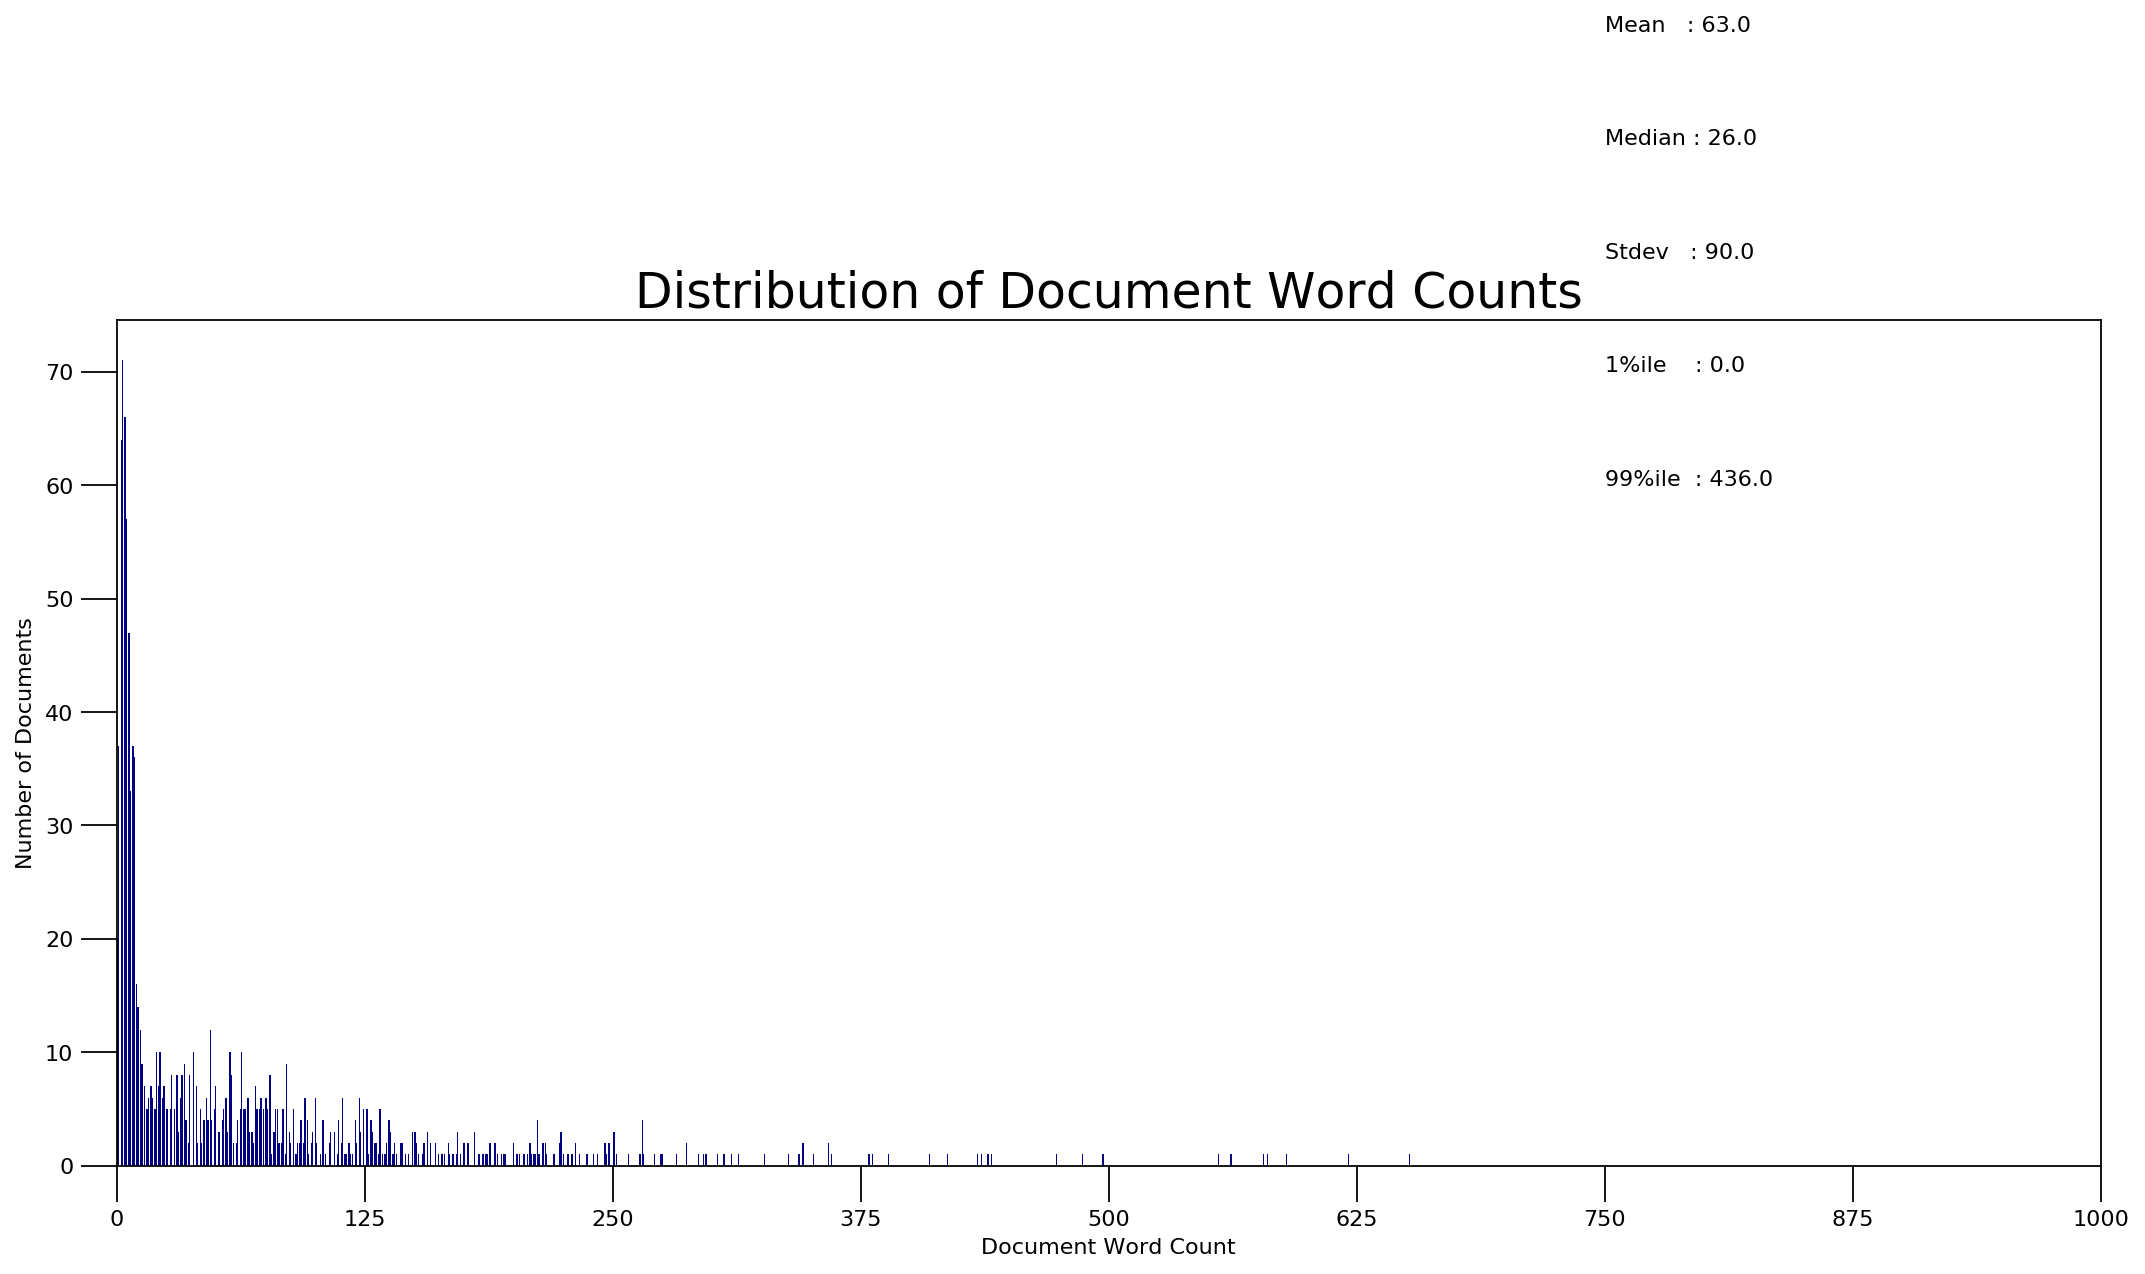

In [38]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

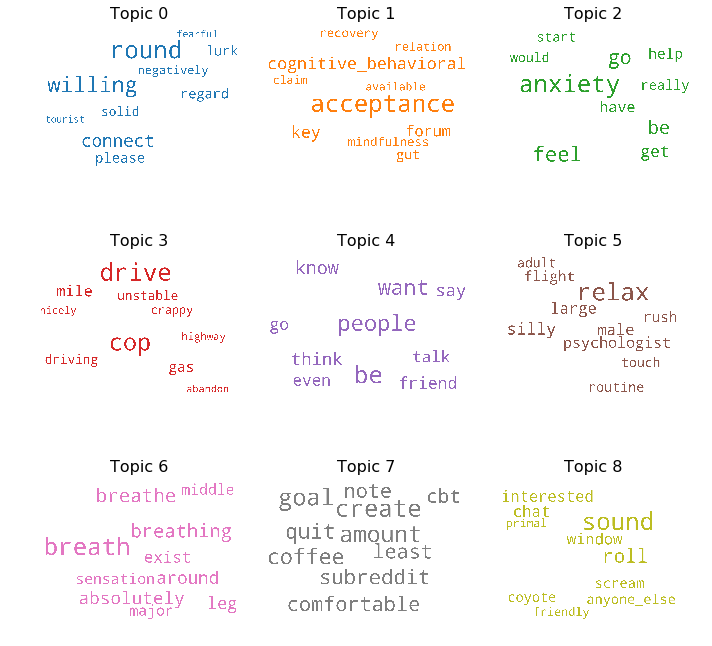

In [39]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [40]:
df_dominant_topic.to_csv("Reddit2012.csv")

In [41]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(alpha='auto', corpus=corpus, num_topics=20, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [26]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=100, step=6)

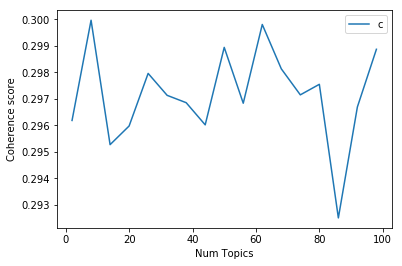

In [27]:
# Show graph
limit=100; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

Thus, number of topics=20 is the best possible choice.